# Afriat

In [1]:
ood_seed = 12

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('24', 'Periportal', 'Uninfected')


Removed datapoint: 1721

train         13852
validation     3480
ood            1721
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 52%|█████▏    | 9919/19053 [00:00<00:00, 99185.84it/s]

100%|██████████| 19053/19053 [00:00<00:00, 100056.18it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1034339.11it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 364.87it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:14<1:36:56, 14.58s/it]

Epoch 1/400:   0%|          | 1/400 [00:14<1:36:56, 14.58s/it, v_num=1, recon=4.09e+3, r2_mean=0.179, adv_loss=3.34, acc_pert=0.261, acc_zone=0.704, acc_status_control=0.477]

Epoch 2/400:   0%|          | 1/400 [00:14<1:36:56, 14.58s/it, v_num=1, recon=4.09e+3, r2_mean=0.179, adv_loss=3.34, acc_pert=0.261, acc_zone=0.704, acc_status_control=0.477]

Epoch 2/400:   0%|          | 2/400 [00:23<1:15:41, 11.41s/it, v_num=1, recon=4.09e+3, r2_mean=0.179, adv_loss=3.34, acc_pert=0.261, acc_zone=0.704, acc_status_control=0.477]

Epoch 2/400:   0%|          | 2/400 [00:23<1:15:41, 11.41s/it, v_num=1, recon=3.33e+3, r2_mean=0.601, adv_loss=2.91, acc_pert=0.378, acc_zone=0.801, acc_status_control=0.602]

Epoch 3/400:   0%|          | 2/400 [00:23<1:15:41, 11.41s/it, v_num=1, recon=3.33e+3, r2_mean=0.601, adv_loss=2.91, acc_pert=0.378, acc_zone=0.801, acc_status_control=0.602]

Epoch 3/400:   1%|          | 3/400 [00:33<1:09:17, 10.47s/it, v_num=1, recon=3.33e+3, r2_mean=0.601, adv_loss=2.91, acc_pert=0.378, acc_zone=0.801, acc_status_control=0.602]

Epoch 3/400:   1%|          | 3/400 [00:33<1:09:17, 10.47s/it, v_num=1, recon=3.26e+3, r2_mean=0.71, adv_loss=2.8, acc_pert=0.385, acc_zone=0.817, acc_status_control=0.603]  

Epoch 4/400:   1%|          | 3/400 [00:33<1:09:17, 10.47s/it, v_num=1, recon=3.26e+3, r2_mean=0.71, adv_loss=2.8, acc_pert=0.385, acc_zone=0.817, acc_status_control=0.603]

Epoch 4/400:   1%|          | 4/400 [00:42<1:05:38,  9.94s/it, v_num=1, recon=3.26e+3, r2_mean=0.71, adv_loss=2.8, acc_pert=0.385, acc_zone=0.817, acc_status_control=0.603]

Epoch 4/400:   1%|          | 4/400 [00:42<1:05:38,  9.94s/it, v_num=1, recon=3.24e+3, r2_mean=0.746, adv_loss=2.83, acc_pert=0.378, acc_zone=0.823, acc_status_control=0.582]

Epoch 5/400:   1%|          | 4/400 [00:42<1:05:38,  9.94s/it, v_num=1, recon=3.24e+3, r2_mean=0.746, adv_loss=2.83, acc_pert=0.378, acc_zone=0.823, acc_status_control=0.582]

Epoch 5/400:   1%|▏         | 5/400 [00:51<1:03:40,  9.67s/it, v_num=1, recon=3.24e+3, r2_mean=0.746, adv_loss=2.83, acc_pert=0.378, acc_zone=0.823, acc_status_control=0.582]

Epoch 5/400:   1%|▏         | 5/400 [00:51<1:03:40,  9.67s/it, v_num=1, recon=3.23e+3, r2_mean=0.769, adv_loss=2.69, acc_pert=0.436, acc_zone=0.83, acc_status_control=0.577] 

Epoch 6/400:   1%|▏         | 5/400 [00:51<1:03:40,  9.67s/it, v_num=1, recon=3.23e+3, r2_mean=0.769, adv_loss=2.69, acc_pert=0.436, acc_zone=0.83, acc_status_control=0.577]

Epoch 6/400:   2%|▏         | 6/400 [01:01<1:03:22,  9.65s/it, v_num=1, recon=3.23e+3, r2_mean=0.769, adv_loss=2.69, acc_pert=0.436, acc_zone=0.83, acc_status_control=0.577]

Epoch 6/400:   2%|▏         | 6/400 [01:01<1:03:22,  9.65s/it, v_num=1, recon=3.22e+3, r2_mean=0.785, adv_loss=2.43, acc_pert=0.536, acc_zone=0.842, acc_status_control=0.589]

Epoch 7/400:   2%|▏         | 6/400 [01:01<1:03:22,  9.65s/it, v_num=1, recon=3.22e+3, r2_mean=0.785, adv_loss=2.43, acc_pert=0.536, acc_zone=0.842, acc_status_control=0.589]

Epoch 7/400:   2%|▏         | 7/400 [01:10<1:02:04,  9.48s/it, v_num=1, recon=3.22e+3, r2_mean=0.785, adv_loss=2.43, acc_pert=0.536, acc_zone=0.842, acc_status_control=0.589]

Epoch 7/400:   2%|▏         | 7/400 [01:10<1:02:04,  9.48s/it, v_num=1, recon=3.21e+3, r2_mean=0.793, adv_loss=2.23, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.597]

Epoch 8/400:   2%|▏         | 7/400 [01:10<1:02:04,  9.48s/it, v_num=1, recon=3.21e+3, r2_mean=0.793, adv_loss=2.23, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.597]

Epoch 8/400:   2%|▏         | 8/400 [01:20<1:03:50,  9.77s/it, v_num=1, recon=3.21e+3, r2_mean=0.793, adv_loss=2.23, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.597]

Epoch 8/400:   2%|▏         | 8/400 [01:20<1:03:50,  9.77s/it, v_num=1, recon=3.2e+3, r2_mean=0.802, adv_loss=2.14, acc_pert=0.618, acc_zone=0.849, acc_status_control=0.599] 

Epoch 9/400:   2%|▏         | 8/400 [01:20<1:03:50,  9.77s/it, v_num=1, recon=3.2e+3, r2_mean=0.802, adv_loss=2.14, acc_pert=0.618, acc_zone=0.849, acc_status_control=0.599]

Epoch 9/400:   2%|▏         | 9/400 [01:29<1:02:37,  9.61s/it, v_num=1, recon=3.2e+3, r2_mean=0.802, adv_loss=2.14, acc_pert=0.618, acc_zone=0.849, acc_status_control=0.599]

Epoch 9/400:   2%|▏         | 9/400 [01:29<1:02:37,  9.61s/it, v_num=1, recon=3.19e+3, r2_mean=0.803, adv_loss=2.13, acc_pert=0.628, acc_zone=0.848, acc_status_control=0.599]

Epoch 10/400:   2%|▏         | 9/400 [01:29<1:02:37,  9.61s/it, v_num=1, recon=3.19e+3, r2_mean=0.803, adv_loss=2.13, acc_pert=0.628, acc_zone=0.848, acc_status_control=0.599]


disnt_basal = 1.2433992383279022

disnt_after = 1.943269728882999

val_r2_mean = 0.8104131069796258

val_r2_var = 0.1699380053031965


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:56<1:37:25, 14.99s/it, v_num=1, recon=3.19e+3, r2_mean=0.803, adv_loss=2.13, acc_pert=0.628, acc_zone=0.848, acc_status_control=0.599]

Epoch 10/400:   2%|▎         | 10/400 [01:56<1:37:25, 14.99s/it, v_num=1, recon=3.19e+3, r2_mean=0.81, adv_loss=2.17, acc_pert=0.622, acc_zone=0.846, acc_status_control=0.598, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:56<1:37:25, 14.99s/it, v_num=1, recon=3.19e+3, r2_mean=0.81, adv_loss=2.17, acc_pert=0.622, acc_zone=0.846, acc_status_control=0.598, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:06<1:26:24, 13.33s/it, v_num=1, recon=3.19e+3, r2_mean=0.81, adv_loss=2.17, acc_pert=0.622, acc_zone=0.846, acc_status_control=0.598, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:06<1:26:24, 13.33s/it, v_num=1, recon=3.18e+3, r2_mean=0.812, adv_loss=2.12, acc_pert=0.631, acc_zone=0.849, acc_status_control=0.605, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [02:06<1:26:24, 13.33s/it, v_num=1, recon=3.18e+3, r2_mean=0.812, adv_loss=2.12, acc_pert=0.631, acc_zone=0.849, acc_status_control=0.605, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:15<1:18:42, 12.17s/it, v_num=1, recon=3.18e+3, r2_mean=0.812, adv_loss=2.12, acc_pert=0.631, acc_zone=0.849, acc_status_control=0.605, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:15<1:18:42, 12.17s/it, v_num=1, recon=3.17e+3, r2_mean=0.814, adv_loss=2.05, acc_pert=0.651, acc_zone=0.851, acc_status_control=0.607, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [02:15<1:18:42, 12.17s/it, v_num=1, recon=3.17e+3, r2_mean=0.814, adv_loss=2.05, acc_pert=0.651, acc_zone=0.851, acc_status_control=0.607, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:25<1:13:20, 11.37s/it, v_num=1, recon=3.17e+3, r2_mean=0.814, adv_loss=2.05, acc_pert=0.651, acc_zone=0.851, acc_status_control=0.607, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:25<1:13:20, 11.37s/it, v_num=1, recon=3.17e+3, r2_mean=0.815, adv_loss=2.03, acc_pert=0.66, acc_zone=0.845, acc_status_control=0.621, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [02:25<1:13:20, 11.37s/it, v_num=1, recon=3.17e+3, r2_mean=0.815, adv_loss=2.03, acc_pert=0.66, acc_zone=0.845, acc_status_control=0.621, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:34<1:09:22, 10.78s/it, v_num=1, recon=3.17e+3, r2_mean=0.815, adv_loss=2.03, acc_pert=0.66, acc_zone=0.845, acc_status_control=0.621, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:34<1:09:22, 10.78s/it, v_num=1, recon=3.17e+3, r2_mean=0.818, adv_loss=2.05, acc_pert=0.653, acc_zone=0.849, acc_status_control=0.613, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:34<1:09:22, 10.78s/it, v_num=1, recon=3.17e+3, r2_mean=0.818, adv_loss=2.05, acc_pert=0.653, acc_zone=0.849, acc_status_control=0.613, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:44<1:06:44, 10.40s/it, v_num=1, recon=3.17e+3, r2_mean=0.818, adv_loss=2.05, acc_pert=0.653, acc_zone=0.849, acc_status_control=0.613, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:44<1:06:44, 10.40s/it, v_num=1, recon=3.16e+3, r2_mean=0.819, adv_loss=2.06, acc_pert=0.649, acc_zone=0.854, acc_status_control=0.615, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [02:44<1:06:44, 10.40s/it, v_num=1, recon=3.16e+3, r2_mean=0.819, adv_loss=2.06, acc_pert=0.649, acc_zone=0.854, acc_status_control=0.615, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:53<1:04:44, 10.12s/it, v_num=1, recon=3.16e+3, r2_mean=0.819, adv_loss=2.06, acc_pert=0.649, acc_zone=0.854, acc_status_control=0.615, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:53<1:04:44, 10.12s/it, v_num=1, recon=3.16e+3, r2_mean=0.818, adv_loss=2.08, acc_pert=0.651, acc_zone=0.848, acc_status_control=0.617, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:53<1:04:44, 10.12s/it, v_num=1, recon=3.16e+3, r2_mean=0.818, adv_loss=2.08, acc_pert=0.651, acc_zone=0.848, acc_status_control=0.617, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:03<1:03:18,  9.92s/it, v_num=1, recon=3.16e+3, r2_mean=0.818, adv_loss=2.08, acc_pert=0.651, acc_zone=0.848, acc_status_control=0.617, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:03<1:03:18,  9.92s/it, v_num=1, recon=3.15e+3, r2_mean=0.82, adv_loss=2.08, acc_pert=0.65, acc_zone=0.851, acc_status_control=0.616, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]  

Epoch 18/400:   4%|▍         | 17/400 [03:03<1:03:18,  9.92s/it, v_num=1, recon=3.15e+3, r2_mean=0.82, adv_loss=2.08, acc_pert=0.65, acc_zone=0.851, acc_status_control=0.616, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:12<1:02:25,  9.80s/it, v_num=1, recon=3.15e+3, r2_mean=0.82, adv_loss=2.08, acc_pert=0.65, acc_zone=0.851, acc_status_control=0.616, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:12<1:02:25,  9.80s/it, v_num=1, recon=3.15e+3, r2_mean=0.82, adv_loss=2.1, acc_pert=0.645, acc_zone=0.85, acc_status_control=0.621, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [03:12<1:02:25,  9.80s/it, v_num=1, recon=3.15e+3, r2_mean=0.82, adv_loss=2.1, acc_pert=0.645, acc_zone=0.85, acc_status_control=0.621, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:22<1:01:42,  9.72s/it, v_num=1, recon=3.15e+3, r2_mean=0.82, adv_loss=2.1, acc_pert=0.645, acc_zone=0.85, acc_status_control=0.621, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:22<1:01:42,  9.72s/it, v_num=1, recon=3.15e+3, r2_mean=0.823, adv_loss=2.05, acc_pert=0.651, acc_zone=0.855, acc_status_control=0.631, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [03:22<1:01:42,  9.72s/it, v_num=1, recon=3.15e+3, r2_mean=0.823, adv_loss=2.05, acc_pert=0.651, acc_zone=0.855, acc_status_control=0.631, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]


disnt_basal = 1.2466222626585102

disnt_after = 1.9181771814752986

val_r2_mean = 0.8211928232107928

val_r2_var = 0.22217019351923925

Epoch 20/400:   5%|▌         | 20/400 [03:59<1:53:56, 17.99s/it, v_num=1, recon=3.15e+3, r2_mean=0.823, adv_loss=2.05, acc_pert=0.651, acc_zone=0.855, acc_status_control=0.631, val_recon=3.19e+3, disnt_basal=1.24, disnt_after=1.94, val_r2_mean=0.81, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:59<1:53:56, 17.99s/it, v_num=1, recon=3.14e+3, r2_mean=0.822, adv_loss=2.08, acc_pert=0.66, acc_zone=0.853, acc_status_control=0.617, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [03:59<1:53:56, 17.99s/it, v_num=1, recon=3.14e+3, r2_mean=0.822, adv_loss=2.08, acc_pert=0.66, acc_zone=0.853, acc_status_control=0.617, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:10<1:39:44, 15.79s/it, v_num=1, recon=3.14e+3, r2_mean=0.822, adv_loss=2.08, acc_pert=0.66, acc_zone=0.853, acc_status_control=0.617, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:10<1:39:44, 15.79s/it, v_num=1, recon=3.14e+3, r2_mean=0.823, adv_loss=2.06, acc_pert=0.649, acc_zone=0.852, acc_status_control=0.631, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [04:10<1:39:44, 15.79s/it, v_num=1, recon=3.14e+3, r2_mean=0.823, adv_loss=2.06, acc_pert=0.649, acc_zone=0.852, acc_status_control=0.631, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:19<1:27:17, 13.86s/it, v_num=1, recon=3.14e+3, r2_mean=0.823, adv_loss=2.06, acc_pert=0.649, acc_zone=0.852, acc_status_control=0.631, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:19<1:27:17, 13.86s/it, v_num=1, recon=3.13e+3, r2_mean=0.824, adv_loss=2.05, acc_pert=0.654, acc_zone=0.854, acc_status_control=0.631, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [04:19<1:27:17, 13.86s/it, v_num=1, recon=3.13e+3, r2_mean=0.824, adv_loss=2.05, acc_pert=0.654, acc_zone=0.854, acc_status_control=0.631, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:29<1:18:46, 12.54s/it, v_num=1, recon=3.13e+3, r2_mean=0.824, adv_loss=2.05, acc_pert=0.654, acc_zone=0.854, acc_status_control=0.631, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:29<1:18:46, 12.54s/it, v_num=1, recon=3.13e+3, r2_mean=0.825, adv_loss=2.07, acc_pert=0.658, acc_zone=0.855, acc_status_control=0.625, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [04:29<1:18:46, 12.54s/it, v_num=1, recon=3.13e+3, r2_mean=0.825, adv_loss=2.07, acc_pert=0.658, acc_zone=0.855, acc_status_control=0.625, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [04:42<1:19:32, 12.69s/it, v_num=1, recon=3.13e+3, r2_mean=0.825, adv_loss=2.07, acc_pert=0.658, acc_zone=0.855, acc_status_control=0.625, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [04:42<1:19:32, 12.69s/it, v_num=1, recon=3.13e+3, r2_mean=0.829, adv_loss=2.06, acc_pert=0.657, acc_zone=0.85, acc_status_control=0.632, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [04:42<1:19:32, 12.69s/it, v_num=1, recon=3.13e+3, r2_mean=0.829, adv_loss=2.06, acc_pert=0.657, acc_zone=0.85, acc_status_control=0.632, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:51<1:13:20, 11.74s/it, v_num=1, recon=3.13e+3, r2_mean=0.829, adv_loss=2.06, acc_pert=0.657, acc_zone=0.85, acc_status_control=0.632, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:51<1:13:20, 11.74s/it, v_num=1, recon=3.12e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.653, acc_zone=0.852, acc_status_control=0.64, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [04:51<1:13:20, 11.74s/it, v_num=1, recon=3.12e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.653, acc_zone=0.852, acc_status_control=0.64, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:01<1:08:50, 11.04s/it, v_num=1, recon=3.12e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.653, acc_zone=0.852, acc_status_control=0.64, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:01<1:08:50, 11.04s/it, v_num=1, recon=3.12e+3, r2_mean=0.827, adv_loss=2.06, acc_pert=0.65, acc_zone=0.853, acc_status_control=0.639, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [05:01<1:08:50, 11.04s/it, v_num=1, recon=3.12e+3, r2_mean=0.827, adv_loss=2.06, acc_pert=0.65, acc_zone=0.853, acc_status_control=0.639, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:10<1:05:42, 10.57s/it, v_num=1, recon=3.12e+3, r2_mean=0.827, adv_loss=2.06, acc_pert=0.65, acc_zone=0.853, acc_status_control=0.639, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:10<1:05:42, 10.57s/it, v_num=1, recon=3.12e+3, r2_mean=0.827, adv_loss=2.08, acc_pert=0.639, acc_zone=0.851, acc_status_control=0.636, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [05:10<1:05:42, 10.57s/it, v_num=1, recon=3.12e+3, r2_mean=0.827, adv_loss=2.08, acc_pert=0.639, acc_zone=0.851, acc_status_control=0.636, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:19<1:03:19, 10.21s/it, v_num=1, recon=3.12e+3, r2_mean=0.827, adv_loss=2.08, acc_pert=0.639, acc_zone=0.851, acc_status_control=0.636, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:19<1:03:19, 10.21s/it, v_num=1, recon=3.12e+3, r2_mean=0.827, adv_loss=2.09, acc_pert=0.638, acc_zone=0.853, acc_status_control=0.636, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [05:19<1:03:19, 10.21s/it, v_num=1, recon=3.12e+3, r2_mean=0.827, adv_loss=2.09, acc_pert=0.638, acc_zone=0.853, acc_status_control=0.636, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:29<1:01:33,  9.95s/it, v_num=1, recon=3.12e+3, r2_mean=0.827, adv_loss=2.09, acc_pert=0.638, acc_zone=0.853, acc_status_control=0.636, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:29<1:01:33,  9.95s/it, v_num=1, recon=3.11e+3, r2_mean=0.83, adv_loss=2.08, acc_pert=0.639, acc_zone=0.851, acc_status_control=0.636, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [05:29<1:01:33,  9.95s/it, v_num=1, recon=3.11e+3, r2_mean=0.83, adv_loss=2.08, acc_pert=0.639, acc_zone=0.851, acc_status_control=0.636, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]


disnt_basal = 1.2374481553637102

disnt_after = 1.9131087424212272

val_r2_mean = 0.8164113247913141

val_r2_var = 0.22936484418050931

Epoch 30/400:   8%|▊         | 30/400 [06:27<2:29:50, 24.30s/it, v_num=1, recon=3.11e+3, r2_mean=0.83, adv_loss=2.08, acc_pert=0.639, acc_zone=0.851, acc_status_control=0.636, val_recon=3.16e+3, disnt_basal=1.25, disnt_after=1.92, val_r2_mean=0.821, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [06:27<2:29:50, 24.30s/it, v_num=1, recon=3.11e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.629, acc_zone=0.848, acc_status_control=0.634, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [06:27<2:29:50, 24.30s/it, v_num=1, recon=3.11e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.629, acc_zone=0.848, acc_status_control=0.634, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [06:37<2:03:48, 20.13s/it, v_num=1, recon=3.11e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.629, acc_zone=0.848, acc_status_control=0.634, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [06:37<2:03:48, 20.13s/it, v_num=1, recon=3.11e+3, r2_mean=0.83, adv_loss=2.08, acc_pert=0.64, acc_zone=0.851, acc_status_control=0.642, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]  

Epoch 32/400:   8%|▊         | 31/400 [06:37<2:03:48, 20.13s/it, v_num=1, recon=3.11e+3, r2_mean=0.83, adv_loss=2.08, acc_pert=0.64, acc_zone=0.851, acc_status_control=0.642, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [06:48<1:46:13, 17.32s/it, v_num=1, recon=3.11e+3, r2_mean=0.83, adv_loss=2.08, acc_pert=0.64, acc_zone=0.851, acc_status_control=0.642, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [06:48<1:46:13, 17.32s/it, v_num=1, recon=3.1e+3, r2_mean=0.83, adv_loss=2.1, acc_pert=0.635, acc_zone=0.846, acc_status_control=0.637, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [06:48<1:46:13, 17.32s/it, v_num=1, recon=3.1e+3, r2_mean=0.83, adv_loss=2.1, acc_pert=0.635, acc_zone=0.846, acc_status_control=0.637, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [06:57<1:31:48, 15.01s/it, v_num=1, recon=3.1e+3, r2_mean=0.83, adv_loss=2.1, acc_pert=0.635, acc_zone=0.846, acc_status_control=0.637, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [06:57<1:31:48, 15.01s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.631, acc_zone=0.849, acc_status_control=0.634, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [06:57<1:31:48, 15.01s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.631, acc_zone=0.849, acc_status_control=0.634, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [07:07<1:21:51, 13.42s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.631, acc_zone=0.849, acc_status_control=0.634, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [07:07<1:21:51, 13.42s/it, v_num=1, recon=3.1e+3, r2_mean=0.83, adv_loss=2.13, acc_pert=0.621, acc_zone=0.853, acc_status_control=0.633, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan] 

Epoch 35/400:   8%|▊         | 34/400 [07:07<1:21:51, 13.42s/it, v_num=1, recon=3.1e+3, r2_mean=0.83, adv_loss=2.13, acc_pert=0.621, acc_zone=0.853, acc_status_control=0.633, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:17<1:14:23, 12.23s/it, v_num=1, recon=3.1e+3, r2_mean=0.83, adv_loss=2.13, acc_pert=0.621, acc_zone=0.853, acc_status_control=0.633, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:17<1:14:23, 12.23s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.631, acc_zone=0.852, acc_status_control=0.637, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [07:17<1:14:23, 12.23s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.631, acc_zone=0.852, acc_status_control=0.637, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:26<1:09:59, 11.54s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=2.11, acc_pert=0.631, acc_zone=0.852, acc_status_control=0.637, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:26<1:09:59, 11.54s/it, v_num=1, recon=3.09e+3, r2_mean=0.831, adv_loss=2.14, acc_pert=0.619, acc_zone=0.851, acc_status_control=0.637, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [07:26<1:09:59, 11.54s/it, v_num=1, recon=3.09e+3, r2_mean=0.831, adv_loss=2.14, acc_pert=0.619, acc_zone=0.851, acc_status_control=0.637, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [07:36<1:05:58, 10.91s/it, v_num=1, recon=3.09e+3, r2_mean=0.831, adv_loss=2.14, acc_pert=0.619, acc_zone=0.851, acc_status_control=0.637, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [07:36<1:05:58, 10.91s/it, v_num=1, recon=3.09e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.616, acc_zone=0.85, acc_status_control=0.636, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan] 

Epoch 38/400:   9%|▉         | 37/400 [07:36<1:05:58, 10.91s/it, v_num=1, recon=3.09e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.616, acc_zone=0.85, acc_status_control=0.636, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [07:45<1:03:04, 10.45s/it, v_num=1, recon=3.09e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.616, acc_zone=0.85, acc_status_control=0.636, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [07:45<1:03:04, 10.45s/it, v_num=1, recon=3.09e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.618, acc_zone=0.851, acc_status_control=0.635, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [07:45<1:03:04, 10.45s/it, v_num=1, recon=3.09e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.618, acc_zone=0.851, acc_status_control=0.635, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [07:55<1:00:59, 10.14s/it, v_num=1, recon=3.09e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.618, acc_zone=0.851, acc_status_control=0.635, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [07:55<1:00:59, 10.14s/it, v_num=1, recon=3.08e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.609, acc_zone=0.853, acc_status_control=0.636, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [07:55<1:00:59, 10.14s/it, v_num=1, recon=3.08e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.609, acc_zone=0.853, acc_status_control=0.636, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]


disnt_basal = 1.2342283503071163

disnt_after = 1.9066590481908448

val_r2_mean = 0.8300803252544086

val_r2_var = 0.25255742515661533

Epoch 40/400:  10%|█         | 40/400 [08:33<1:51:34, 18.60s/it, v_num=1, recon=3.08e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.609, acc_zone=0.853, acc_status_control=0.636, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.816, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [08:33<1:51:34, 18.60s/it, v_num=1, recon=3.08e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.607, acc_zone=0.851, acc_status_control=0.633, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]   

Epoch 41/400:  10%|█         | 40/400 [08:33<1:51:34, 18.60s/it, v_num=1, recon=3.08e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.607, acc_zone=0.851, acc_status_control=0.633, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [08:43<1:34:58, 15.87s/it, v_num=1, recon=3.08e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.607, acc_zone=0.851, acc_status_control=0.633, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [08:43<1:34:58, 15.87s/it, v_num=1, recon=3.08e+3, r2_mean=0.83, adv_loss=2.19, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.633, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [08:43<1:34:58, 15.87s/it, v_num=1, recon=3.08e+3, r2_mean=0.83, adv_loss=2.19, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.633, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [08:52<1:23:36, 14.01s/it, v_num=1, recon=3.08e+3, r2_mean=0.83, adv_loss=2.19, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.633, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [08:52<1:23:36, 14.01s/it, v_num=1, recon=3.08e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.636, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [08:52<1:23:36, 14.01s/it, v_num=1, recon=3.08e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.636, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:02<1:15:04, 12.62s/it, v_num=1, recon=3.08e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.636, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:02<1:15:04, 12.62s/it, v_num=1, recon=3.08e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.632, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [09:02<1:15:04, 12.62s/it, v_num=1, recon=3.08e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.632, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [09:11<1:08:59, 11.63s/it, v_num=1, recon=3.08e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.632, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [09:11<1:08:59, 11.63s/it, v_num=1, recon=3.07e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.608, acc_zone=0.848, acc_status_control=0.638, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [09:11<1:08:59, 11.63s/it, v_num=1, recon=3.07e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.608, acc_zone=0.848, acc_status_control=0.638, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [09:20<1:04:42, 10.94s/it, v_num=1, recon=3.07e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.608, acc_zone=0.848, acc_status_control=0.638, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [09:20<1:04:42, 10.94s/it, v_num=1, recon=3.07e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.614, acc_zone=0.847, acc_status_control=0.637, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [09:20<1:04:42, 10.94s/it, v_num=1, recon=3.07e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.614, acc_zone=0.847, acc_status_control=0.637, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [09:30<1:02:38, 10.62s/it, v_num=1, recon=3.07e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.614, acc_zone=0.847, acc_status_control=0.637, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [09:30<1:02:38, 10.62s/it, v_num=1, recon=3.07e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.615, acc_zone=0.847, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan] 

Epoch 47/400:  12%|█▏        | 46/400 [09:30<1:02:38, 10.62s/it, v_num=1, recon=3.07e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.615, acc_zone=0.847, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [09:40<1:00:24, 10.27s/it, v_num=1, recon=3.07e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.615, acc_zone=0.847, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [09:40<1:00:24, 10.27s/it, v_num=1, recon=3.06e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.618, acc_zone=0.845, acc_status_control=0.637, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [09:40<1:00:24, 10.27s/it, v_num=1, recon=3.06e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.618, acc_zone=0.845, acc_status_control=0.637, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [09:49<58:39, 10.00s/it, v_num=1, recon=3.06e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.618, acc_zone=0.845, acc_status_control=0.637, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]  

Epoch 48/400:  12%|█▏        | 48/400 [09:49<58:39, 10.00s/it, v_num=1, recon=3.06e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan] 

Epoch 49/400:  12%|█▏        | 48/400 [09:49<58:39, 10.00s/it, v_num=1, recon=3.06e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [09:58<57:36,  9.85s/it, v_num=1, recon=3.06e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [09:58<57:36,  9.85s/it, v_num=1, recon=3.06e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.638, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [09:58<57:36,  9.85s/it, v_num=1, recon=3.06e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.638, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2226817104295638

disnt_after = 1.918163881362174

val_r2_mean = 0.8273496517297703

val_r2_var = 0.2569716091228091


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [10:33<1:40:53, 17.30s/it, v_num=1, recon=3.06e+3, r2_mean=0.834, adv_loss=2.17, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.638, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [10:33<1:40:53, 17.30s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.603, acc_zone=0.848, acc_status_control=0.64, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [10:33<1:40:53, 17.30s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.603, acc_zone=0.848, acc_status_control=0.64, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [10:44<1:29:36, 15.40s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.603, acc_zone=0.848, acc_status_control=0.64, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [10:44<1:29:36, 15.40s/it, v_num=1, recon=3.06e+3, r2_mean=0.833, adv_loss=2.19, acc_pert=0.597, acc_zone=0.845, acc_status_control=0.635, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [10:44<1:29:36, 15.40s/it, v_num=1, recon=3.06e+3, r2_mean=0.833, adv_loss=2.19, acc_pert=0.597, acc_zone=0.845, acc_status_control=0.635, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [10:54<1:20:32, 13.89s/it, v_num=1, recon=3.06e+3, r2_mean=0.833, adv_loss=2.19, acc_pert=0.597, acc_zone=0.845, acc_status_control=0.635, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [10:54<1:20:32, 13.89s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.599, acc_zone=0.845, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [10:54<1:20:32, 13.89s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.599, acc_zone=0.845, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [11:05<1:14:20, 12.85s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.599, acc_zone=0.845, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [11:05<1:14:20, 12.85s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.594, acc_zone=0.847, acc_status_control=0.633, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [11:05<1:14:20, 12.85s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.594, acc_zone=0.847, acc_status_control=0.633, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [11:15<1:09:49, 12.11s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.594, acc_zone=0.847, acc_status_control=0.633, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [11:15<1:09:49, 12.11s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.589, acc_zone=0.846, acc_status_control=0.635, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [11:15<1:09:49, 12.11s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.589, acc_zone=0.846, acc_status_control=0.635, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [11:26<1:06:37, 11.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.589, acc_zone=0.846, acc_status_control=0.635, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [11:26<1:06:37, 11.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.592, acc_zone=0.842, acc_status_control=0.634, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [11:26<1:06:37, 11.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.592, acc_zone=0.842, acc_status_control=0.634, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [11:36<1:04:16, 11.21s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.592, acc_zone=0.842, acc_status_control=0.634, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [11:36<1:04:16, 11.21s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.593, acc_zone=0.842, acc_status_control=0.634, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [11:36<1:04:16, 11.21s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.593, acc_zone=0.842, acc_status_control=0.634, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [11:46<1:02:35, 10.95s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.593, acc_zone=0.842, acc_status_control=0.634, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [11:46<1:02:35, 10.95s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.588, acc_zone=0.845, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [11:46<1:02:35, 10.95s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.588, acc_zone=0.845, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [11:57<1:01:28, 10.79s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.588, acc_zone=0.845, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [11:57<1:01:28, 10.79s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.592, acc_zone=0.843, acc_status_control=0.636, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [11:57<1:01:28, 10.79s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.592, acc_zone=0.843, acc_status_control=0.636, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [12:07<1:01:18, 10.79s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.592, acc_zone=0.843, acc_status_control=0.636, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [12:07<1:01:18, 10.79s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.586, acc_zone=0.841, acc_status_control=0.633, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [12:07<1:01:18, 10.79s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.586, acc_zone=0.841, acc_status_control=0.633, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.219666784602761

disnt_after = 1.911122328935866

val_r2_mean = 0.8271427111172417

val_r2_var = 0.2617817871524971

Epoch 60/400:  15%|█▌        | 60/400 [13:04<2:19:25, 24.61s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.586, acc_zone=0.841, acc_status_control=0.633, val_recon=3.08e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.827, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [13:04<2:19:25, 24.61s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.595, acc_zone=0.838, acc_status_control=0.635, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [13:04<2:19:25, 24.61s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.595, acc_zone=0.838, acc_status_control=0.635, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [13:15<1:55:49, 20.50s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.595, acc_zone=0.838, acc_status_control=0.635, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [13:15<1:55:49, 20.50s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.592, acc_zone=0.841, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [13:15<1:55:49, 20.50s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.592, acc_zone=0.841, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [13:25<1:36:48, 17.19s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.592, acc_zone=0.841, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [13:25<1:36:48, 17.19s/it, v_num=1, recon=3.04e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.587, acc_zone=0.842, acc_status_control=0.639, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [13:25<1:36:48, 17.19s/it, v_num=1, recon=3.04e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.587, acc_zone=0.842, acc_status_control=0.639, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [13:34<1:23:29, 14.86s/it, v_num=1, recon=3.04e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.587, acc_zone=0.842, acc_status_control=0.639, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [13:34<1:23:29, 14.86s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.635, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [13:34<1:23:29, 14.86s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.635, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [13:43<1:13:55, 13.20s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.635, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [13:43<1:13:55, 13.20s/it, v_num=1, recon=3.03e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.591, acc_zone=0.846, acc_status_control=0.633, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [13:43<1:13:55, 13.20s/it, v_num=1, recon=3.03e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.591, acc_zone=0.846, acc_status_control=0.633, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [13:53<1:07:22, 12.07s/it, v_num=1, recon=3.03e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.591, acc_zone=0.846, acc_status_control=0.633, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [13:53<1:07:22, 12.07s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.587, acc_zone=0.839, acc_status_control=0.63, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [13:53<1:07:22, 12.07s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.587, acc_zone=0.839, acc_status_control=0.63, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [14:02<1:02:52, 11.30s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.587, acc_zone=0.839, acc_status_control=0.63, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [14:02<1:02:52, 11.30s/it, v_num=1, recon=3.03e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.584, acc_zone=0.839, acc_status_control=0.629, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [14:02<1:02:52, 11.30s/it, v_num=1, recon=3.03e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.584, acc_zone=0.839, acc_status_control=0.629, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [14:12<59:25, 10.71s/it, v_num=1, recon=3.03e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.584, acc_zone=0.839, acc_status_control=0.629, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]  

Epoch 67/400:  17%|█▋        | 67/400 [14:12<59:25, 10.71s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.593, acc_zone=0.842, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [14:12<59:25, 10.71s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.593, acc_zone=0.842, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [14:21<57:15, 10.35s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.593, acc_zone=0.842, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [14:21<57:15, 10.35s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.583, acc_zone=0.842, acc_status_control=0.636, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [14:21<57:15, 10.35s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.583, acc_zone=0.842, acc_status_control=0.636, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [14:31<55:38, 10.09s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.583, acc_zone=0.842, acc_status_control=0.636, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [14:31<55:38, 10.09s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.58, acc_zone=0.843, acc_status_control=0.627, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan] 

Epoch 70/400:  17%|█▋        | 69/400 [14:31<55:38, 10.09s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.58, acc_zone=0.843, acc_status_control=0.627, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.220618717474171

disnt_after = 1.9068169416079586

val_r2_mean = 0.8304634792581301

val_r2_var = 0.24871509045502754

Epoch 70/400:  18%|█▊        | 70/400 [15:26<2:10:02, 23.64s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.58, acc_zone=0.843, acc_status_control=0.627, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [15:26<2:10:02, 23.64s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.588, acc_zone=0.841, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [15:26<2:10:02, 23.64s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.588, acc_zone=0.841, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [15:37<1:48:15, 19.74s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.588, acc_zone=0.841, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [15:37<1:48:15, 19.74s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.589, acc_zone=0.843, acc_status_control=0.63, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [15:37<1:48:15, 19.74s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.589, acc_zone=0.843, acc_status_control=0.63, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [15:46<1:30:57, 16.64s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.589, acc_zone=0.843, acc_status_control=0.63, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [15:46<1:30:57, 16.64s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.576, acc_zone=0.84, acc_status_control=0.63, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [15:46<1:30:57, 16.64s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.576, acc_zone=0.84, acc_status_control=0.63, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [15:57<1:20:58, 14.86s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.576, acc_zone=0.84, acc_status_control=0.63, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [15:57<1:20:58, 14.86s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [15:57<1:20:58, 14.86s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [16:08<1:14:30, 13.71s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [16:08<1:14:30, 13.71s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.581, acc_zone=0.842, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [16:08<1:14:30, 13.71s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.581, acc_zone=0.842, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [16:18<1:09:11, 12.77s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.581, acc_zone=0.842, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [16:18<1:09:11, 12.77s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.841, acc_status_control=0.634, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan] 

Epoch 76/400:  19%|█▉        | 75/400 [16:18<1:09:11, 12.77s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.841, acc_status_control=0.634, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [16:29<1:05:13, 12.08s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.841, acc_status_control=0.634, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [16:29<1:05:13, 12.08s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [16:29<1:05:13, 12.08s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [16:39<1:02:20, 11.58s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.631, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [16:39<1:02:20, 11.58s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.576, acc_zone=0.836, acc_status_control=0.633, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [16:39<1:02:20, 11.58s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.576, acc_zone=0.836, acc_status_control=0.633, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [16:50<1:00:13, 11.22s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.576, acc_zone=0.836, acc_status_control=0.633, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [16:50<1:00:13, 11.22s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.579, acc_zone=0.838, acc_status_control=0.632, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [16:50<1:00:13, 11.22s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.579, acc_zone=0.838, acc_status_control=0.632, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [17:00<58:55, 11.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.579, acc_zone=0.838, acc_status_control=0.632, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]  

Epoch 79/400:  20%|█▉        | 79/400 [17:00<58:55, 11.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.588, acc_zone=0.84, acc_status_control=0.628, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [17:00<58:55, 11.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.588, acc_zone=0.84, acc_status_control=0.628, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2082360141406527

disnt_after = 1.9100093056580805

val_r2_mean = 0.8333108554963805

val_r2_var = 0.2683909643411206


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [17:38<1:41:19, 19.00s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.588, acc_zone=0.84, acc_status_control=0.628, val_recon=3.07e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.83, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [17:38<1:41:19, 19.00s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.578, acc_zone=0.836, acc_status_control=0.631, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [17:38<1:41:19, 19.00s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.578, acc_zone=0.836, acc_status_control=0.631, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [17:47<1:26:08, 16.20s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.578, acc_zone=0.836, acc_status_control=0.631, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [17:47<1:26:08, 16.20s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.632, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [17:47<1:26:08, 16.20s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.632, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [17:57<1:15:21, 14.22s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.632, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [17:57<1:15:21, 14.22s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.837, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan] 

Epoch 83/400:  20%|██        | 82/400 [17:57<1:15:21, 14.22s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.837, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [18:06<1:07:35, 12.79s/it, v_num=1, recon=3.01e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.58, acc_zone=0.837, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [18:06<1:07:35, 12.79s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.633, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]  

Epoch 84/400:  21%|██        | 83/400 [18:06<1:07:35, 12.79s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.633, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [18:16<1:02:20, 11.84s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.633, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [18:16<1:02:20, 11.84s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.578, acc_zone=0.839, acc_status_control=0.635, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [18:16<1:02:20, 11.84s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.578, acc_zone=0.839, acc_status_control=0.635, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [18:27<1:00:39, 11.55s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.578, acc_zone=0.839, acc_status_control=0.635, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [18:27<1:00:39, 11.55s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.575, acc_zone=0.835, acc_status_control=0.63, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [18:27<1:00:39, 11.55s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.575, acc_zone=0.835, acc_status_control=0.63, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [18:36<57:03, 10.90s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.575, acc_zone=0.835, acc_status_control=0.63, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]  

Epoch 86/400:  22%|██▏       | 86/400 [18:36<57:03, 10.90s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.578, acc_zone=0.84, acc_status_control=0.637, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [18:36<57:03, 10.90s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.578, acc_zone=0.84, acc_status_control=0.637, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [18:46<54:53, 10.52s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.578, acc_zone=0.84, acc_status_control=0.637, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [18:46<54:53, 10.52s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [18:46<54:53, 10.52s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [18:57<55:31, 10.68s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [18:57<55:31, 10.68s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.57, acc_zone=0.835, acc_status_control=0.627, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan] 

Epoch 89/400:  22%|██▏       | 88/400 [18:57<55:31, 10.68s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.57, acc_zone=0.835, acc_status_control=0.627, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [19:07<53:31, 10.32s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.57, acc_zone=0.835, acc_status_control=0.627, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [19:07<53:31, 10.32s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.631, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [19:07<53:31, 10.32s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.631, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.2096655984932003

disnt_after = 1.9096834842365562

val_r2_mean = 0.8307453733454747

val_r2_var = 0.26023698815197827

Epoch 90/400:  22%|██▎       | 90/400 [19:50<1:45:02, 20.33s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.631, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.833, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [19:50<1:45:02, 20.33s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.63, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan] 

Epoch 91/400:  22%|██▎       | 90/400 [19:50<1:45:02, 20.33s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.63, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [20:00<1:27:48, 17.05s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.63, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [20:00<1:27:48, 17.05s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.627, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [20:00<1:27:48, 17.05s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.627, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [20:09<1:15:42, 14.75s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.627, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [20:09<1:15:42, 14.75s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.577, acc_zone=0.837, acc_status_control=0.633, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [20:09<1:15:42, 14.75s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.577, acc_zone=0.837, acc_status_control=0.633, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [20:18<1:07:06, 13.12s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.577, acc_zone=0.837, acc_status_control=0.633, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [20:18<1:07:06, 13.12s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [20:18<1:07:06, 13.12s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [20:28<1:01:04, 11.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [20:28<1:01:04, 11.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.627, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]  

Epoch 95/400:  24%|██▎       | 94/400 [20:28<1:01:04, 11.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.627, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [20:37<57:19, 11.28s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.627, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]  

Epoch 95/400:  24%|██▍       | 95/400 [20:37<57:19, 11.28s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.574, acc_zone=0.833, acc_status_control=0.634, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [20:37<57:19, 11.28s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.574, acc_zone=0.833, acc_status_control=0.634, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [20:47<54:12, 10.70s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.574, acc_zone=0.833, acc_status_control=0.634, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [20:47<54:12, 10.70s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.573, acc_zone=0.836, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [20:47<54:12, 10.70s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.573, acc_zone=0.836, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [20:56<51:54, 10.28s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.573, acc_zone=0.836, acc_status_control=0.629, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [20:56<51:54, 10.28s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.634, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [20:56<51:54, 10.28s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.634, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [21:05<50:16,  9.99s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.634, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [21:05<50:16,  9.99s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.631, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [21:05<50:16,  9.99s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.631, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [21:15<49:03,  9.78s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.631, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [21:15<49:03,  9.78s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.628, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [21:15<49:03,  9.78s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.628, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.2074062099181073

disnt_after = 1.9107544921429567

val_r2_mean = 0.8264653291622172

val_r2_var = 0.2712822560330249

Epoch 100/400:  25%|██▌       | 100/400 [22:11<1:59:24, 23.88s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.628, val_recon=3.05e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [22:11<1:59:24, 23.88s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.629, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [22:11<1:59:24, 23.88s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.629, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [22:21<1:38:07, 19.69s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.629, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [22:21<1:38:07, 19.69s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.629, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [22:21<1:38:07, 19.69s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.629, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [22:30<1:22:09, 16.54s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.629, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [22:30<1:22:09, 16.54s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [22:30<1:22:09, 16.54s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [22:41<1:13:08, 14.78s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [22:41<1:13:08, 14.78s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.574, acc_zone=0.836, acc_status_control=0.63, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [22:41<1:13:08, 14.78s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.574, acc_zone=0.836, acc_status_control=0.63, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [22:50<1:04:52, 13.15s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.574, acc_zone=0.836, acc_status_control=0.63, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [22:50<1:04:52, 13.15s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [22:50<1:04:52, 13.15s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [23:00<58:57, 11.99s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]  

Epoch 105/400:  26%|██▋       | 105/400 [23:00<58:57, 11.99s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.636, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan] 

Epoch 106/400:  26%|██▋       | 105/400 [23:00<58:57, 11.99s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.636, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [23:09<54:34, 11.14s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.636, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [23:09<54:34, 11.14s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.574, acc_zone=0.838, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [23:09<54:34, 11.14s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.574, acc_zone=0.838, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [23:18<51:30, 10.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.574, acc_zone=0.838, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [23:18<51:30, 10.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [23:18<51:30, 10.55s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [23:27<49:23, 10.15s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [23:27<49:23, 10.15s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan] 

Epoch 109/400:  27%|██▋       | 108/400 [23:27<49:23, 10.15s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [23:36<47:54,  9.88s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.57, acc_zone=0.84, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [23:36<47:54,  9.88s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.573, acc_zone=0.835, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [23:36<47:54,  9.88s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.573, acc_zone=0.835, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1988572184743063

disnt_after = 1.9088901279200126

val_r2_mean = 0.8254280525549336

val_r2_var = 0.26029837744466017


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [24:11<1:23:27, 17.27s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.573, acc_zone=0.835, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.826, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [24:11<1:23:27, 17.27s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.63, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]  

Epoch 111/400:  28%|██▊       | 110/400 [24:11<1:23:27, 17.27s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.63, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [24:20<1:11:50, 14.92s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.63, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [24:20<1:11:50, 14.92s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [24:20<1:11:50, 14.92s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [24:30<1:03:55, 13.32s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [24:30<1:03:55, 13.32s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]  

Epoch 113/400:  28%|██▊       | 112/400 [24:30<1:03:55, 13.32s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [24:40<58:12, 12.17s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]  

Epoch 113/400:  28%|██▊       | 113/400 [24:40<58:12, 12.17s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [24:40<58:12, 12.17s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [24:49<54:44, 11.48s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [24:49<54:44, 11.48s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [24:49<54:44, 11.48s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [24:59<51:40, 10.88s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [24:59<51:40, 10.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [24:59<51:40, 10.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [25:08<49:21, 10.43s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [25:08<49:21, 10.43s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [25:08<49:21, 10.43s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [25:18<47:42, 10.12s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [25:18<47:42, 10.12s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.571, acc_zone=0.839, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [25:18<47:42, 10.12s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.571, acc_zone=0.839, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [25:27<46:34,  9.91s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.571, acc_zone=0.839, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [25:27<46:34,  9.91s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [25:27<46:34,  9.91s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [25:36<45:45,  9.77s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [25:37<45:45,  9.77s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [25:37<45:45,  9.77s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1965787109434365

disnt_after = 1.8990052732661014

val_r2_mean = 0.8374482201951519

val_r2_var = 0.2754040215920281


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [26:27<1:42:29, 21.96s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.825, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [26:27<1:42:29, 21.96s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [26:27<1:42:29, 21.96s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [26:36<1:24:44, 18.22s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [26:36<1:24:44, 18.22s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [26:36<1:24:44, 18.22s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [26:46<1:12:09, 15.57s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [26:46<1:12:09, 15.57s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [26:46<1:12:09, 15.57s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [26:55<1:03:21, 13.73s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [26:55<1:03:21, 13.73s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.572, acc_zone=0.837, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [26:55<1:03:21, 13.73s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.572, acc_zone=0.837, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [27:05<57:09, 12.42s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.572, acc_zone=0.837, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]  

Epoch 124/400:  31%|███       | 124/400 [27:05<57:09, 12.42s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [27:05<57:09, 12.42s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [27:14<52:50, 11.53s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [27:14<52:50, 11.53s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [27:14<52:50, 11.53s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [27:24<49:49, 10.91s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [27:24<49:49, 10.91s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [27:24<49:49, 10.91s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [27:33<47:36, 10.46s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [27:33<47:36, 10.46s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [27:33<47:36, 10.46s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [27:42<45:59, 10.15s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [27:42<45:59, 10.15s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [27:42<45:59, 10.15s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [27:52<44:55,  9.95s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [27:52<44:55,  9.95s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan] 

Epoch 130/400:  32%|███▏      | 129/400 [27:52<44:55,  9.95s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]


disnt_basal = 1.196011680602251

disnt_after = 1.9061278403730146

val_r2_mean = 0.8307371146056941

val_r2_var = 0.26857863774828905


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [28:41<1:38:13, 21.83s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.837, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [28:41<1:38:13, 21.83s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.626, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [28:41<1:38:13, 21.83s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.626, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [28:51<1:21:14, 18.12s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.626, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [28:51<1:21:14, 18.12s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [28:51<1:21:14, 18.12s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [29:00<1:09:17, 15.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [29:00<1:09:17, 15.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.559, acc_zone=0.839, acc_status_control=0.628, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [29:00<1:09:17, 15.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.559, acc_zone=0.839, acc_status_control=0.628, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [29:10<1:00:51, 13.67s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.559, acc_zone=0.839, acc_status_control=0.628, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [29:10<1:00:51, 13.67s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [29:10<1:00:51, 13.67s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [29:19<54:53, 12.38s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]  

Epoch 134/400:  34%|███▎      | 134/400 [29:19<54:53, 12.38s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [29:19<54:53, 12.38s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [29:28<50:46, 11.50s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [29:28<50:46, 11.50s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [29:28<50:46, 11.50s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [29:44<55:34, 12.63s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [29:44<55:34, 12.63s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [29:44<55:34, 12.63s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [29:53<51:02, 11.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [29:53<51:02, 11.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.638, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan] 

Epoch 138/400:  34%|███▍      | 137/400 [29:53<51:02, 11.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.638, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [30:03<48:02, 11.00s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.638, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [30:03<48:02, 11.00s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [30:03<48:02, 11.00s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [30:12<45:46, 10.52s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [30:12<45:46, 10.52s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.632, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [30:12<45:46, 10.52s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.632, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1873150300218207

disnt_after = 1.9034821572873681

val_r2_mean = 0.831699434644262

val_r2_var = 0.2734162299134546


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [31:03<1:38:06, 22.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.632, val_recon=3.01e+3, disnt_basal=1.2, disnt_after=1.91, val_r2_mean=0.831, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [31:03<1:38:06, 22.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.57, acc_zone=0.834, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]  

Epoch 141/400:  35%|███▌      | 140/400 [31:03<1:38:06, 22.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.57, acc_zone=0.834, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [31:12<1:20:28, 18.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.57, acc_zone=0.834, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [31:12<1:20:28, 18.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [31:12<1:20:28, 18.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [31:30<1:18:31, 18.26s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [31:30<1:18:31, 18.26s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan] 

Epoch 143/400:  36%|███▌      | 142/400 [31:30<1:18:31, 18.26s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [31:39<1:06:53, 15.62s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [31:39<1:06:53, 15.62s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [31:39<1:06:53, 15.62s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [31:48<58:38, 13.74s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]  

Epoch 144/400:  36%|███▌      | 144/400 [31:48<58:38, 13.74s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [31:48<58:38, 13.74s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [31:58<52:46, 12.42s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [31:58<52:46, 12.42s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [31:58<52:46, 12.42s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [32:07<48:42, 11.51s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [32:07<48:42, 11.51s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan] 

Epoch 147/400:  36%|███▋      | 146/400 [32:07<48:42, 11.51s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [32:16<45:50, 10.87s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [32:16<45:50, 10.87s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [32:16<45:50, 10.87s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [32:26<43:42, 10.40s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [32:26<43:42, 10.40s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan] 

Epoch 149/400:  37%|███▋      | 148/400 [32:26<43:42, 10.40s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [32:35<42:13, 10.09s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [32:35<42:13, 10.09s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [32:35<42:13, 10.09s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.189343504357802

disnt_after = 1.9110384895382098

val_r2_mean = 0.8274944060025008

val_r2_var = 0.28464753401100845


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [33:11<1:14:28, 17.88s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.832, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [33:11<1:14:28, 17.88s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [33:11<1:14:28, 17.88s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [33:21<1:03:45, 15.36s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [33:21<1:03:45, 15.36s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [33:21<1:03:45, 15.36s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [33:30<55:52, 13.52s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]  

Epoch 152/400:  38%|███▊      | 152/400 [33:30<55:52, 13.52s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan] 

Epoch 153/400:  38%|███▊      | 152/400 [33:30<55:52, 13.52s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [33:39<50:41, 12.31s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [33:39<50:41, 12.31s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [33:39<50:41, 12.31s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [33:49<46:49, 11.42s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [33:49<46:49, 11.42s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [33:49<46:49, 11.42s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [33:58<43:57, 10.76s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [33:58<43:57, 10.76s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [33:58<43:57, 10.76s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [34:10<44:53, 11.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [34:10<44:53, 11.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [34:10<44:53, 11.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [34:19<42:16, 10.44s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [34:19<42:16, 10.44s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan] 

Epoch 158/400:  39%|███▉      | 157/400 [34:19<42:16, 10.44s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [34:28<40:22, 10.01s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [34:28<40:22, 10.01s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [34:28<40:22, 10.01s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [34:37<39:04,  9.73s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [34:37<39:04,  9.73s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [34:37<39:04,  9.73s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1866726581046536

disnt_after = 1.8960023734694318

val_r2_mean = 0.8284622006000557

val_r2_var = 0.2731259616535779

Epoch 160/400:  40%|████      | 160/400 [35:21<1:20:32, 20.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [35:21<1:20:32, 20.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.834, acc_status_control=0.631, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [35:21<1:20:32, 20.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.834, acc_status_control=0.631, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [35:32<1:08:27, 17.19s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.834, acc_status_control=0.631, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [35:32<1:08:27, 17.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [35:32<1:08:27, 17.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [35:41<58:48, 14.83s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]  

Epoch 162/400:  40%|████      | 162/400 [35:41<58:48, 14.83s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [35:41<58:48, 14.83s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [35:50<52:18, 13.24s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [35:50<52:18, 13.24s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [35:50<52:18, 13.24s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [36:00<47:39, 12.12s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [36:00<47:39, 12.12s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [36:00<47:39, 12.12s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [36:09<44:11, 11.28s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [36:09<44:11, 11.28s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [36:09<44:11, 11.28s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [36:19<41:49, 10.72s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [36:19<41:49, 10.72s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [36:19<41:49, 10.72s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [36:28<40:05, 10.32s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.561, acc_zone=0.839, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [36:28<40:05, 10.32s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [36:28<40:05, 10.32s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [36:37<38:51, 10.05s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [36:37<38:51, 10.05s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.556, acc_zone=0.835, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan] 

Epoch 169/400:  42%|████▏     | 168/400 [36:37<38:51, 10.05s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.556, acc_zone=0.835, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [36:47<38:03,  9.89s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.556, acc_zone=0.835, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [36:47<38:03,  9.89s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [36:47<38:03,  9.89s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.188741815581943

disnt_after = 1.8838717683691748

val_r2_mean = 0.8291091070148368

val_r2_var = 0.28177441234503964

Epoch 170/400:  42%|████▎     | 170/400 [37:46<1:34:09, 24.56s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [37:46<1:34:09, 24.56s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]  

Epoch 171/400:  42%|████▎     | 170/400 [37:46<1:34:09, 24.56s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [37:55<1:16:12, 19.97s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [37:55<1:16:12, 19.97s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [37:55<1:16:12, 19.97s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [38:04<1:03:51, 16.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [38:04<1:03:51, 16.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.56, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]   

Epoch 173/400:  43%|████▎     | 172/400 [38:04<1:03:51, 16.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.56, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [38:14<55:37, 14.70s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.56, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]  

Epoch 173/400:  43%|████▎     | 173/400 [38:14<55:37, 14.70s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [38:14<55:37, 14.70s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [38:24<49:19, 13.09s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [38:24<49:19, 13.09s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan] 

Epoch 175/400:  44%|████▎     | 174/400 [38:24<49:19, 13.09s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [38:33<44:52, 11.97s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [38:33<44:52, 11.97s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.559, acc_zone=0.839, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [38:33<44:52, 11.97s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.559, acc_zone=0.839, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [38:42<41:45, 11.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.559, acc_zone=0.839, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [38:42<41:45, 11.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.556, acc_zone=0.835, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [38:42<41:45, 11.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.556, acc_zone=0.835, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [38:52<39:31, 10.63s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.556, acc_zone=0.835, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [38:52<39:31, 10.63s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [38:52<39:31, 10.63s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [39:01<37:53, 10.24s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [39:01<37:53, 10.24s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [39:01<37:53, 10.24s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [39:16<42:49, 11.63s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [39:16<42:49, 11.63s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]  

Epoch 180/400:  45%|████▍     | 179/400 [39:16<42:49, 11.63s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.1807320464632947

disnt_after = 1.8914687647600317

val_r2_mean = 0.8340017196297195

val_r2_var = 0.29713006196555014

Epoch 180/400:  45%|████▌     | 180/400 [40:07<1:26:41, 23.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [40:07<1:26:41, 23.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [40:07<1:26:41, 23.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [40:17<1:10:36, 19.34s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [40:17<1:10:36, 19.34s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [40:17<1:10:36, 19.34s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [40:26<59:24, 16.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]  

Epoch 182/400:  46%|████▌     | 182/400 [40:26<59:24, 16.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [40:26<59:24, 16.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [40:35<51:31, 14.25s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [40:35<51:31, 14.25s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [40:35<51:31, 14.25s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [40:45<45:56, 12.76s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [40:45<45:56, 12.76s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [40:45<45:56, 12.76s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [40:54<42:00, 11.72s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [40:54<42:00, 11.72s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [40:54<42:00, 11.72s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [41:04<39:23, 11.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [41:04<39:23, 11.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.642, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [41:04<39:23, 11.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.642, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [41:13<37:22, 10.53s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.642, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [41:13<37:22, 10.53s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [41:13<37:22, 10.53s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [41:22<35:52, 10.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [41:22<35:52, 10.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]  

Epoch 189/400:  47%|████▋     | 188/400 [41:22<35:52, 10.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [41:31<34:45,  9.89s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [41:31<34:45,  9.89s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.84, acc_status_control=0.638, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [41:31<34:45,  9.89s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.84, acc_status_control=0.638, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1810416162350346

disnt_after = 1.8952676859620403

val_r2_mean = 0.8312984736710909

val_r2_var = 0.2886818333541942

Epoch 190/400:  48%|████▊     | 190/400 [42:12<1:06:21, 18.96s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.84, acc_status_control=0.638, val_recon=3.01e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.834, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [42:12<1:06:21, 18.96s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]    

Epoch 191/400:  48%|████▊     | 190/400 [42:12<1:06:21, 18.96s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [42:21<56:16, 16.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]  

Epoch 191/400:  48%|████▊     | 191/400 [42:21<56:16, 16.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [42:21<56:16, 16.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [42:31<48:57, 14.12s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [42:31<48:57, 14.12s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [42:31<48:57, 14.12s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [42:40<43:54, 12.73s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [42:40<43:54, 12.73s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [42:40<43:54, 12.73s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [42:49<40:14, 11.72s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [42:49<40:14, 11.72s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [42:49<40:14, 11.72s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [42:59<37:41, 11.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [42:59<37:41, 11.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [42:59<37:41, 11.03s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [43:08<35:48, 10.53s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [43:08<35:48, 10.53s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [43:08<35:48, 10.53s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [43:18<34:29, 10.20s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [43:18<34:29, 10.20s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [43:18<34:29, 10.20s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [43:27<33:38,  9.99s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [43:27<33:38,  9.99s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [43:27<33:38,  9.99s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [43:43<39:37, 11.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [43:43<39:37, 11.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [43:43<39:37, 11.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1725569795449677

disnt_after = 1.8863929710248581

val_r2_mean = 0.8278144213572819

val_r2_var = 0.2963109611624457

Epoch 200/400:  50%|█████     | 200/400 [44:26<1:10:07, 21.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.9, val_r2_mean=0.831, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [44:26<1:10:07, 21.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [44:26<1:10:07, 21.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [44:35<58:10, 17.54s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.84, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]  

Epoch 201/400:  50%|█████     | 201/400 [44:35<58:10, 17.54s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [44:35<58:10, 17.54s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [44:45<49:51, 15.11s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [44:45<49:51, 15.11s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [44:45<49:51, 15.11s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [44:54<43:56, 13.38s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [44:54<43:56, 13.38s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [44:54<43:56, 13.38s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [45:03<39:47, 12.18s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.639, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [45:03<39:47, 12.18s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 205/400:  51%|█████     | 204/400 [45:03<39:47, 12.18s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [45:13<36:50, 11.34s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [45:13<36:50, 11.34s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.64, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 206/400:  51%|█████▏    | 205/400 [45:13<36:50, 11.34s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.64, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [45:22<35:07, 10.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.64, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [45:22<35:07, 10.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [45:22<35:07, 10.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [45:32<33:28, 10.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [45:32<33:28, 10.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 208/400:  52%|█████▏    | 207/400 [45:32<33:28, 10.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [45:41<32:16, 10.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [45:41<32:16, 10.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [45:41<32:16, 10.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [45:51<31:46,  9.98s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [45:51<31:46,  9.98s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [45:51<31:46,  9.98s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1930371105962887

disnt_after = 1.8904711015881612

val_r2_mean = 0.8265232698592607

val_r2_var = 0.28896376537031526

Epoch 210/400:  52%|█████▎    | 210/400 [46:42<1:10:55, 22.40s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [46:42<1:10:55, 22.40s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan] 

Epoch 211/400:  52%|█████▎    | 210/400 [46:42<1:10:55, 22.40s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [46:53<59:21, 18.84s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]  

Epoch 211/400:  53%|█████▎    | 211/400 [46:53<59:21, 18.84s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [46:53<59:21, 18.84s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [47:02<49:58, 15.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [47:02<49:58, 15.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [47:02<49:58, 15.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [47:11<43:35, 13.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [47:11<43:35, 13.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.644, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [47:11<43:35, 13.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.644, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [47:21<39:17, 12.67s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.644, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [47:21<39:17, 12.67s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [47:21<39:17, 12.67s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [47:30<35:48, 11.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [47:30<35:48, 11.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.556, acc_zone=0.834, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [47:30<35:48, 11.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.556, acc_zone=0.834, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [47:39<33:24, 10.89s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.556, acc_zone=0.834, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [47:39<33:24, 10.89s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.64, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan] 

Epoch 217/400:  54%|█████▍    | 216/400 [47:39<33:24, 10.89s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.64, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [47:48<31:38, 10.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.64, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [47:48<31:38, 10.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [47:48<31:38, 10.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [47:58<30:25, 10.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [47:58<30:25, 10.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [47:58<30:25, 10.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [48:07<29:34,  9.80s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.558, acc_zone=0.839, acc_status_control=0.645, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [48:07<29:34,  9.80s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [48:07<29:34,  9.80s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1802910708858043

disnt_after = 1.8769674298463326

val_r2_mean = 0.8327947253687012

val_r2_var = 0.28125225919752206

Epoch 220/400:  55%|█████▌    | 220/400 [48:40<50:37, 16.87s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [48:40<50:37, 16.87s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]   

Epoch 221/400:  55%|█████▌    | 220/400 [48:40<50:37, 16.87s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [48:50<43:56, 14.73s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [48:50<43:56, 14.73s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.645, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [48:50<43:56, 14.73s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.645, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [48:59<38:55, 13.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.645, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [48:59<38:55, 13.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan] 

Epoch 223/400:  56%|█████▌    | 222/400 [48:59<38:55, 13.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [49:09<35:24, 12.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.566, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [49:09<35:24, 12.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [49:09<35:24, 12.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [49:18<32:52, 11.21s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [49:18<32:52, 11.21s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [49:18<32:52, 11.21s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [49:28<31:05, 10.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [49:28<31:05, 10.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [49:28<31:05, 10.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [49:37<29:48, 10.28s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [49:37<29:48, 10.28s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan] 

Epoch 227/400:  56%|█████▋    | 226/400 [49:37<29:48, 10.28s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [49:46<28:47,  9.98s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [49:46<28:47,  9.98s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [49:46<28:47,  9.98s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [49:56<28:03,  9.79s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [49:56<28:03,  9.79s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [49:56<28:03,  9.79s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [50:05<27:29,  9.65s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [50:05<27:29,  9.65s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan] 

Epoch 230/400:  57%|█████▋    | 229/400 [50:05<27:29,  9.65s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1684164163659827

disnt_after = 1.8895880806447116

val_r2_mean = 0.8239829569141965

val_r2_var = 0.2836553619039953

Epoch 230/400:  57%|█████▊    | 230/400 [50:45<53:18, 18.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [50:45<53:18, 18.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [50:45<53:18, 18.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [50:55<45:09, 16.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.644, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [50:55<45:09, 16.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan] 

Epoch 232/400:  58%|█████▊    | 231/400 [50:55<45:09, 16.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [51:04<39:21, 14.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [51:04<39:21, 14.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [51:04<39:21, 14.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [51:13<35:13, 12.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [51:13<35:13, 12.66s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [51:13<35:13, 12.66s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [51:23<32:26, 11.73s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [51:23<32:26, 11.73s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [51:23<32:26, 11.73s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [51:32<30:22, 11.05s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [51:32<30:22, 11.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan] 

Epoch 236/400:  59%|█████▉    | 235/400 [51:32<30:22, 11.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [51:42<28:55, 10.58s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [51:42<28:55, 10.58s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [51:42<28:55, 10.58s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [51:51<27:49, 10.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [51:51<27:49, 10.24s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan] 

Epoch 238/400:  59%|█████▉    | 237/400 [51:51<27:49, 10.24s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [52:01<27:00, 10.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.647, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [52:01<27:00, 10.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [52:01<27:00, 10.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [52:10<26:20,  9.82s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [52:10<26:20,  9.82s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.558, acc_zone=0.834, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [52:10<26:20,  9.82s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.558, acc_zone=0.834, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.1706593022894238

disnt_after = 1.886652146905648

val_r2_mean = 0.8242932981028462

val_r2_var = 0.2799637552689425

Epoch 240/400:  60%|██████    | 240/400 [52:39<41:36, 15.60s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.558, acc_zone=0.834, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [52:39<41:36, 15.60s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]   

Epoch 241/400:  60%|██████    | 240/400 [52:39<41:36, 15.60s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [52:49<36:27, 13.76s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [52:49<36:27, 13.76s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [52:49<36:27, 13.76s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [52:58<32:43, 12.43s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.644, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [52:58<32:43, 12.43s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [52:58<32:43, 12.43s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [53:08<30:07, 11.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.649, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [53:08<30:07, 11.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.651, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [53:08<30:07, 11.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.651, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [53:17<28:21, 10.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.651, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [53:17<28:21, 10.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.645, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [53:17<28:21, 10.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.645, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [53:26<26:59, 10.45s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.645, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [53:26<26:59, 10.45s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan] 

Epoch 246/400:  61%|██████▏   | 245/400 [53:26<26:59, 10.45s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [53:36<26:12, 10.21s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.643, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [53:36<26:12, 10.21s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [53:36<26:12, 10.21s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [53:45<25:26,  9.98s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [53:45<25:26,  9.98s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [53:45<25:26,  9.98s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [53:55<24:49,  9.80s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.642, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [53:55<24:49,  9.80s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.647, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [53:55<24:49,  9.80s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.647, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [54:04<24:19,  9.66s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.559, acc_zone=0.841, acc_status_control=0.647, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [54:04<24:19,  9.66s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan] 

Epoch 250/400:  62%|██████▏   | 249/400 [54:04<24:19,  9.66s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.1706309217809021

disnt_after = 1.882306512040447

val_r2_mean = 0.8320361859084919

val_r2_var = 0.2820846698940166

Epoch 250/400:  62%|██████▎   | 250/400 [55:02<1:00:35, 24.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.89, val_r2_mean=0.824, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [55:02<1:00:35, 24.24s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan] 

Epoch 250/400:  62%|██████▎   | 250/400 [55:02<33:01, 13.21s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.56, acc_zone=0.837, acc_status_control=0.646, val_recon=3e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]  

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  6%|▌         | 36/596 [00:00<00:01, 356.75it/s]

 14%|█▎        | 81/596 [00:00<00:01, 408.92it/s]

 21%|██▏       | 127/596 [00:00<00:01, 428.11it/s]

 29%|██▉       | 172/596 [00:00<00:00, 436.67it/s]

 37%|███▋      | 218/596 [00:00<00:00, 442.06it/s]

 44%|████▍     | 264/596 [00:00<00:00, 445.56it/s]

 52%|█████▏    | 309/596 [00:00<00:00, 446.86it/s]

 60%|█████▉    | 355/596 [00:00<00:00, 448.15it/s]

 67%|██████▋   | 401/596 [00:00<00:00, 449.34it/s]

 75%|███████▍  | 446/596 [00:01<00:00, 449.21it/s]

 82%|████████▏ | 491/596 [00:01<00:00, 448.53it/s]

 90%|████████▉ | 536/596 [00:01<00:00, 447.92it/s]

 97%|█████████▋| 581/596 [00:01<00:00, 446.39it/s]

100%|██████████| 596/596 [00:01<00:00, 440.58it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

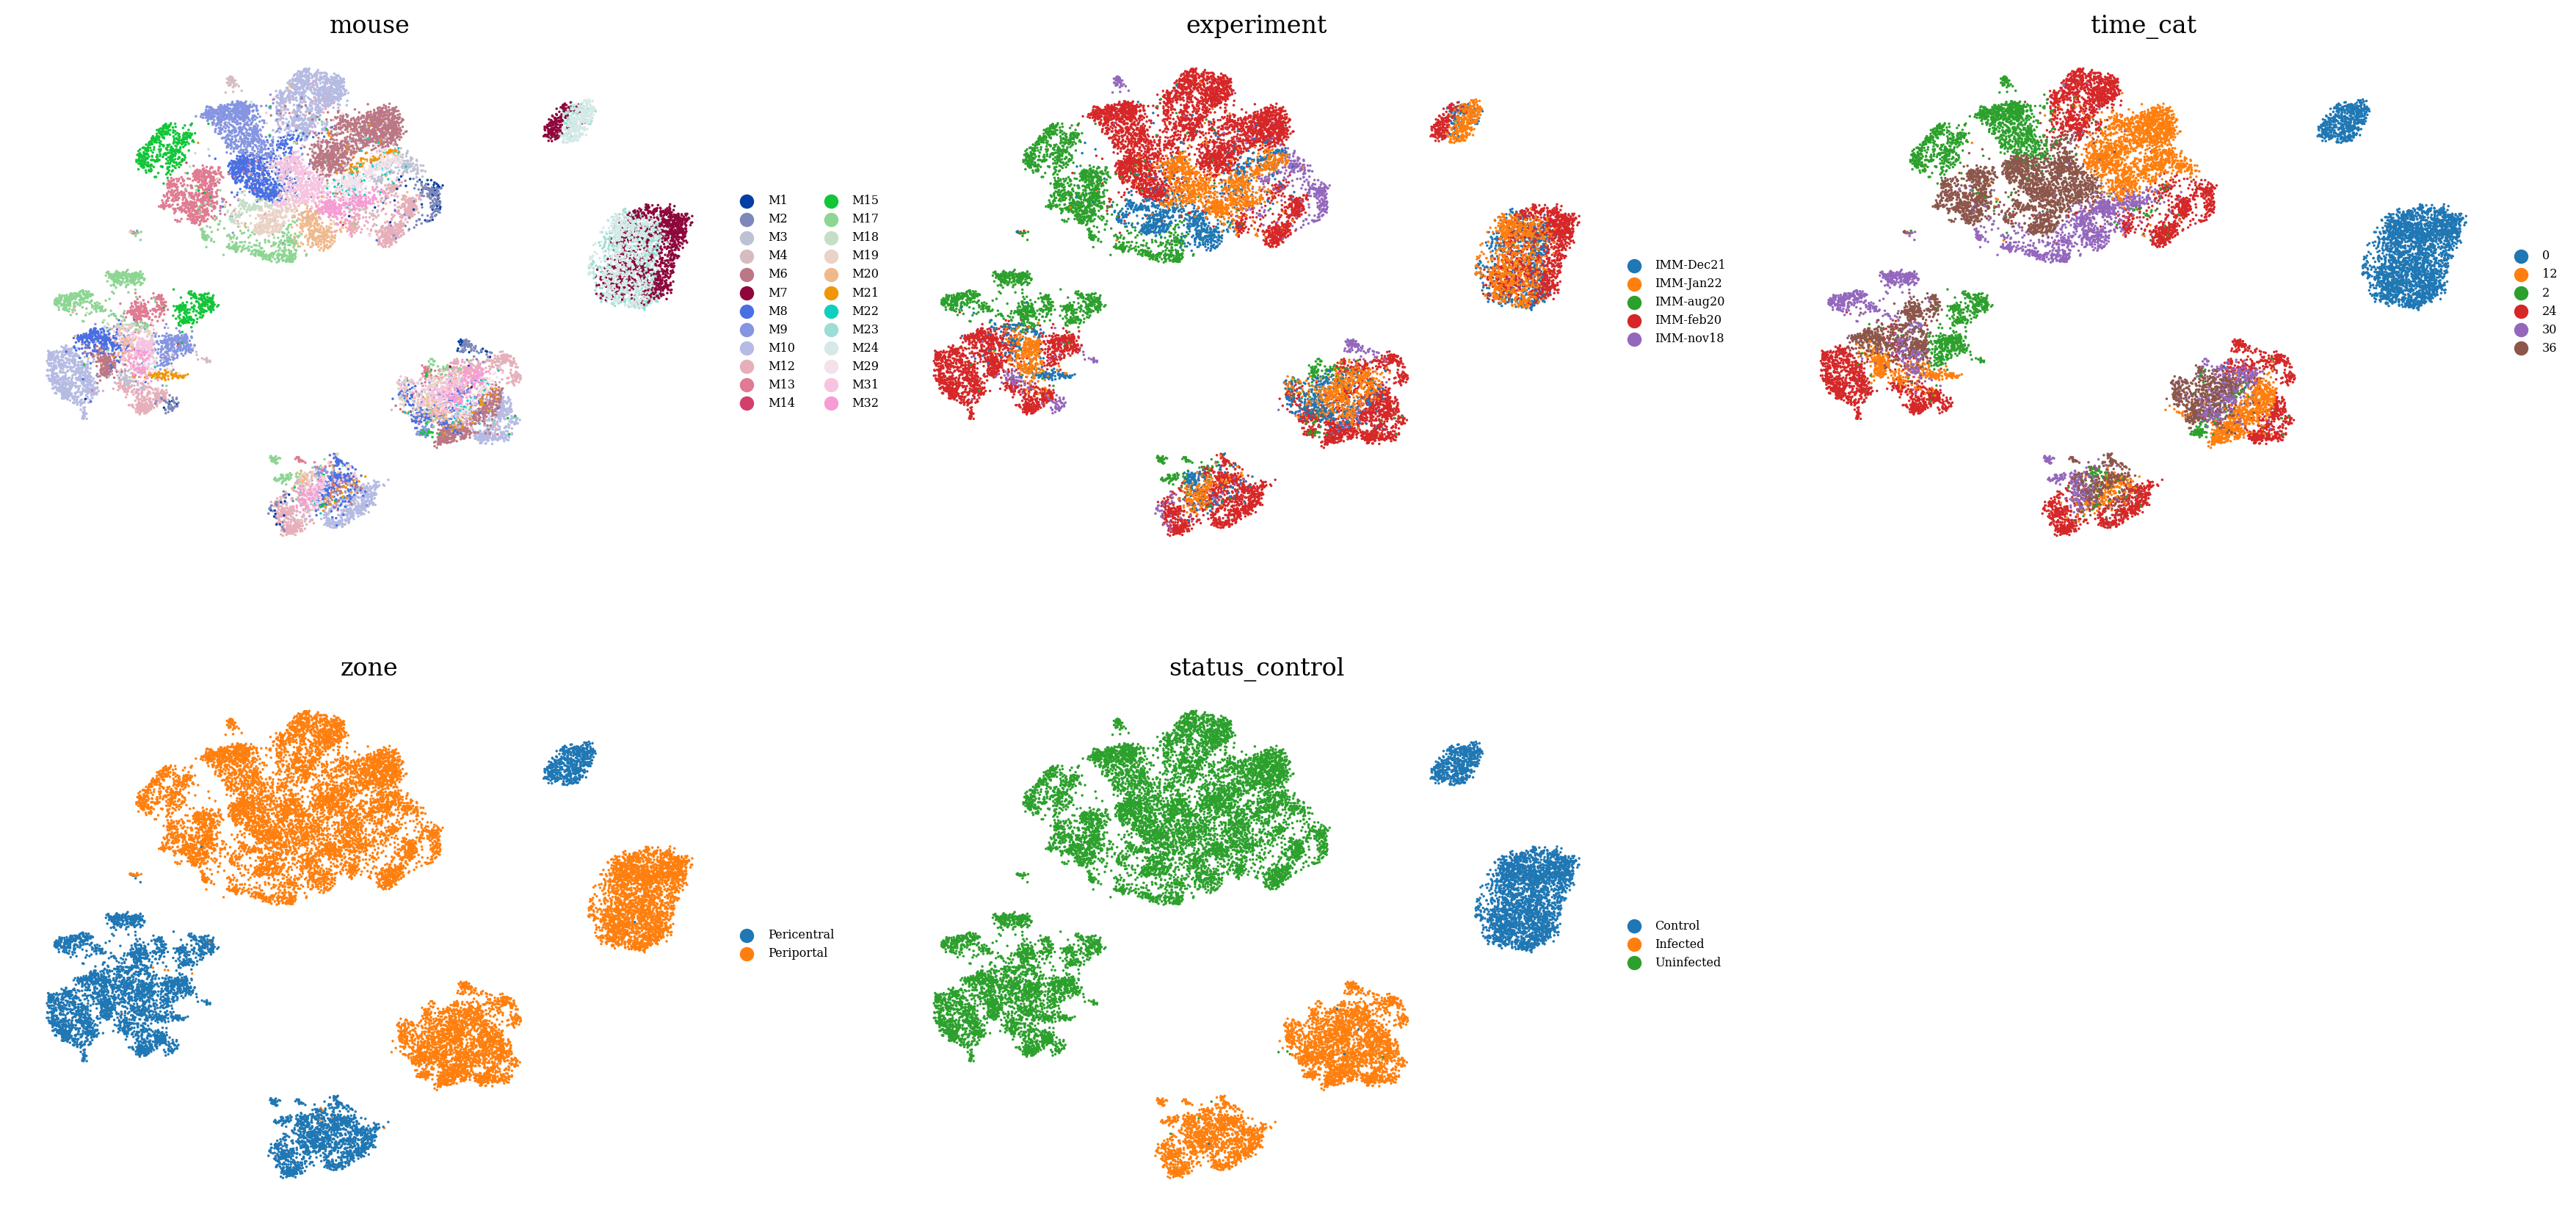

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

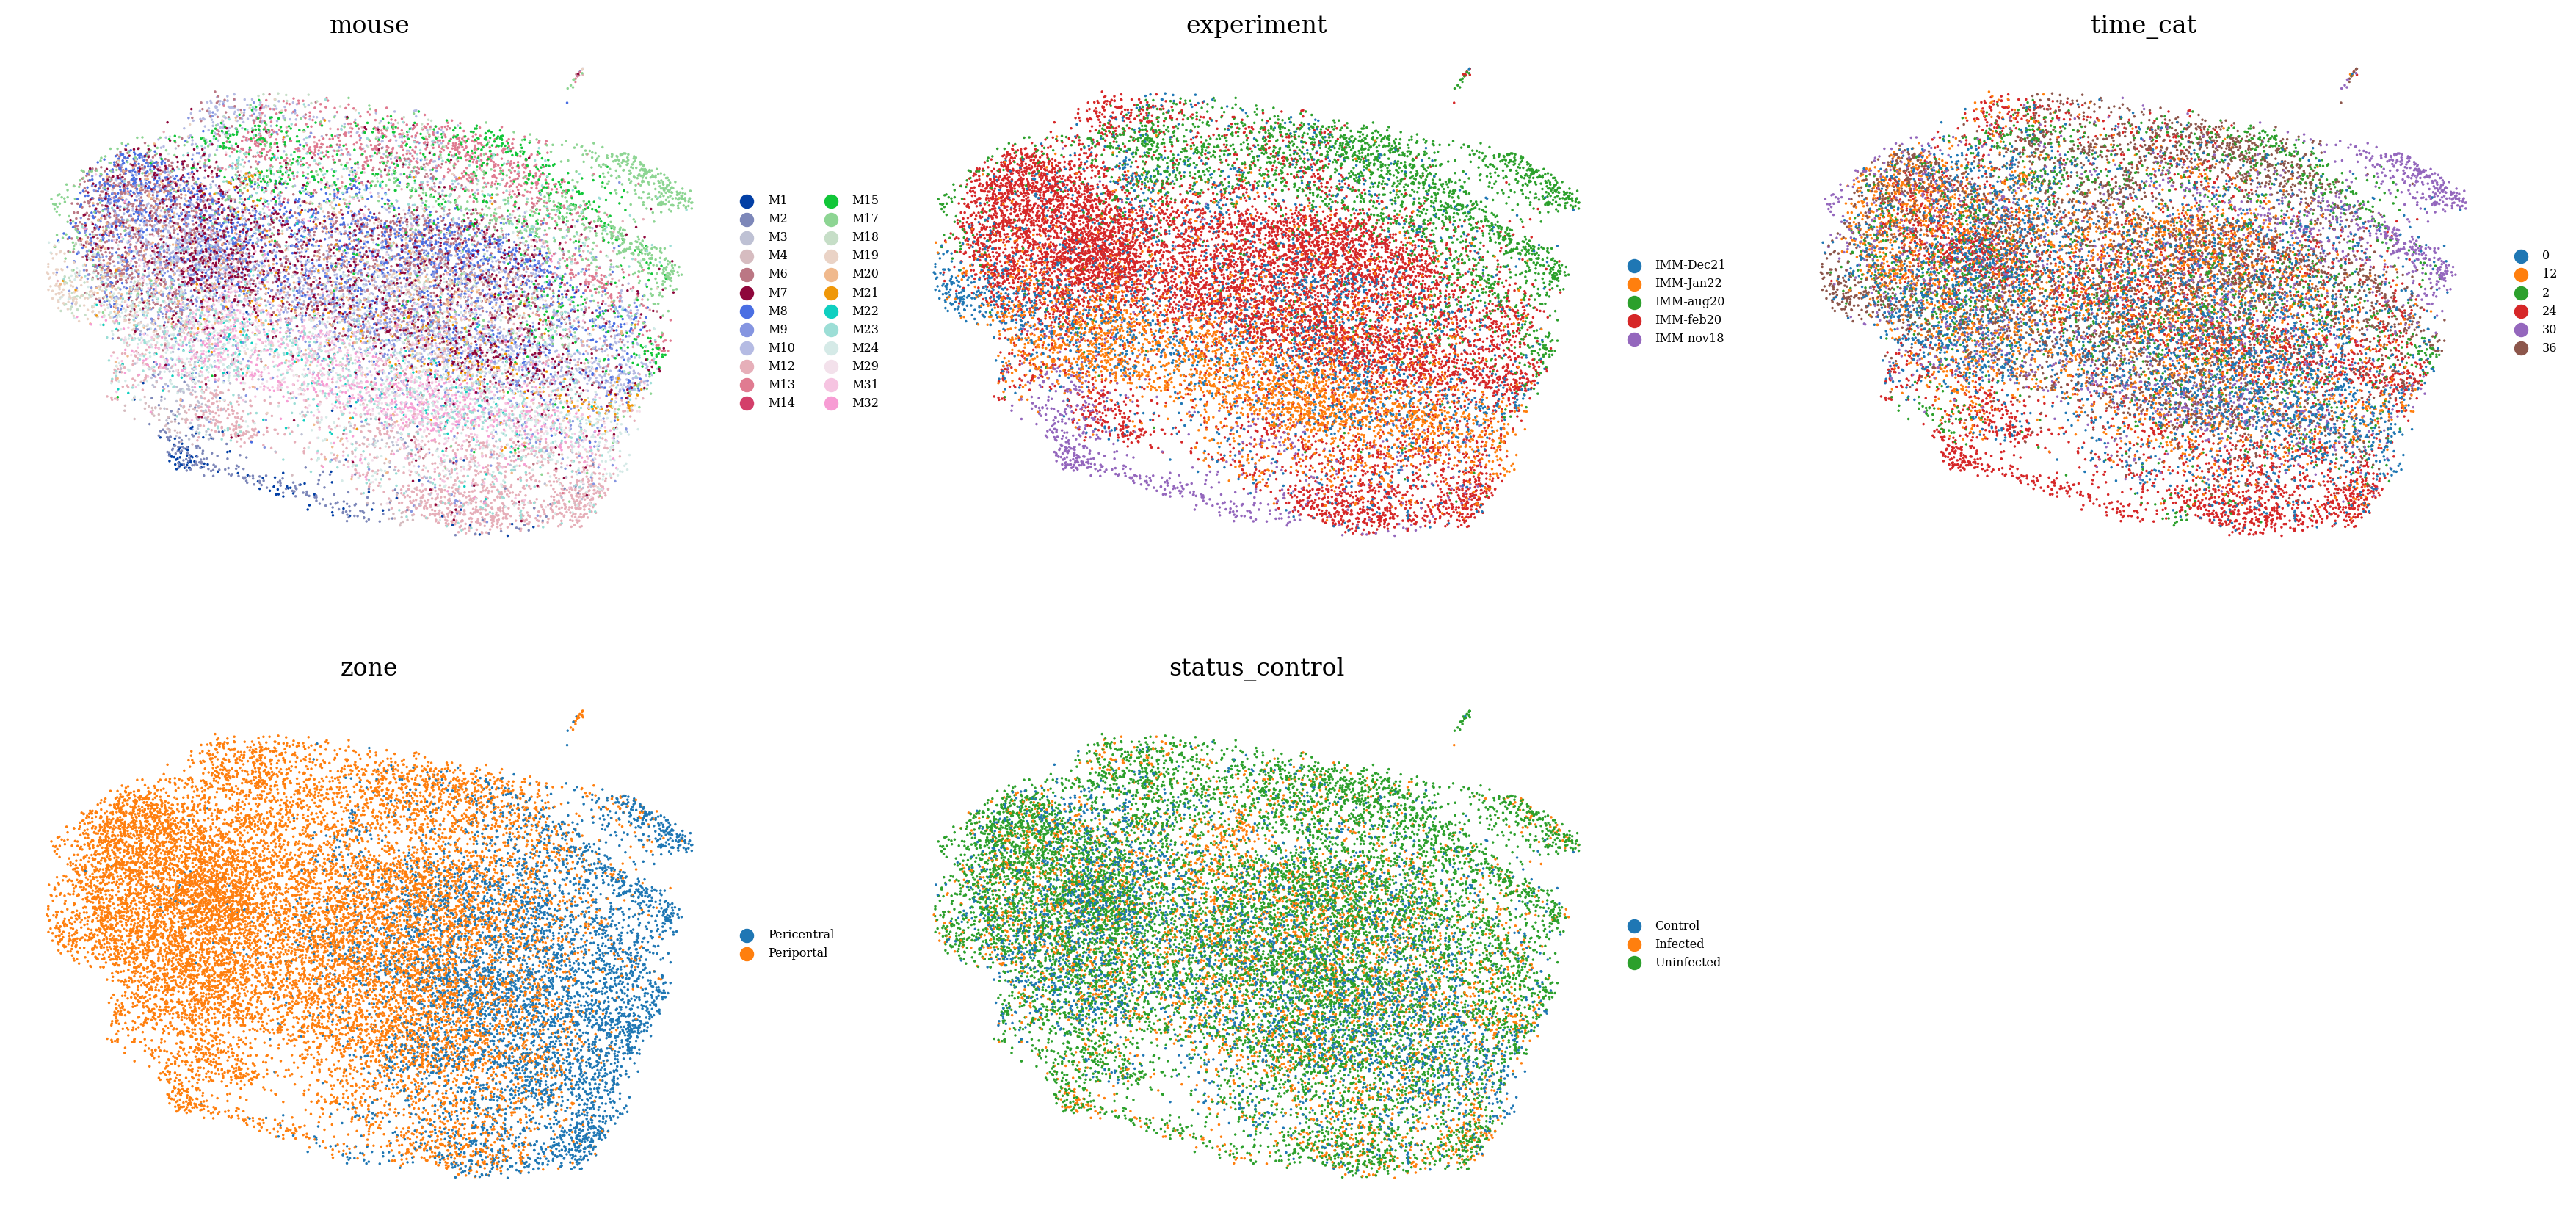

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  2%|▏         | 11/596 [00:00<00:05, 108.60it/s]

  6%|▌         | 37/596 [00:00<00:02, 193.82it/s]

 11%|█         | 63/596 [00:00<00:02, 222.59it/s]

 15%|█▍        | 89/596 [00:00<00:02, 236.50it/s]

 19%|█▉        | 115/596 [00:00<00:01, 243.25it/s]

 23%|██▎       | 140/596 [00:00<00:01, 245.27it/s]

 28%|██▊       | 165/596 [00:00<00:01, 245.98it/s]

 32%|███▏      | 191/596 [00:00<00:01, 247.42it/s]

 36%|███▌      | 216/596 [00:00<00:01, 247.86it/s]

 40%|████      | 241/596 [00:01<00:01, 247.53it/s]

 45%|████▍     | 266/596 [00:01<00:01, 248.07it/s]

 49%|████▉     | 291/596 [00:01<00:01, 248.52it/s]

 53%|█████▎    | 316/596 [00:01<00:01, 248.82it/s]

 57%|█████▋    | 341/596 [00:01<00:01, 248.68it/s]

 61%|██████▏   | 366/596 [00:01<00:00, 249.01it/s]

 66%|██████▌   | 392/596 [00:01<00:00, 249.45it/s]

 70%|██████▉   | 417/596 [00:01<00:00, 248.68it/s]

 74%|███████▍  | 442/596 [00:01<00:00, 248.34it/s]

 78%|███████▊  | 467/596 [00:01<00:00, 248.39it/s]

 83%|████████▎ | 492/596 [00:02<00:00, 248.21it/s]

 87%|████████▋ | 517/596 [00:02<00:00, 245.91it/s]

 91%|█████████ | 542/596 [00:02<00:00, 246.53it/s]

 95%|█████████▌| 567/596 [00:02<00:00, 134.07it/s]

 99%|█████████▉| 592/596 [00:02<00:00, 155.29it/s]

100%|██████████| 596/596 [00:02<00:00, 218.08it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

704

736

736

768

768

800

800

832

832

864

864

896

896

928

928

960

960

992

992

1024

1024

1056

1056

1088

1088

1120

1120

1152

1152

1184

1184

1216

1216

1248

1248

1280

1280

1312

1312

1344

1344

1376

1376

1408

1408

1440

1440

1472

1472

1504

1504

1536

1536

1568

1568

1600

1600

1632

1632

1664

1664

1696

In [23]:
np.mean(r2s)

0.967128552433677

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)